# Bangladesh Flood Forecast


### Webscarping / Data Collection


In [1]:
# import logging
# import pandas as pd
# from tqdm.notebook import tqdm
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as ec
# from selenium.webdriver.common.action_chains import ActionChains

# logging.basicConfig(level=logging.INFO,
#                     format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
# options = webdriver.ChromeOptions()
# options.add_argument('--start-maximized')
# # options.add_argument('--headless')
# driver = webdriver.Chrome(options=options)

In [3]:
# driver.get('https://global-flood-database.cloudtostreet.ai/#interactive-map')

In [4]:
# input_country = WebDriverWait(driver, 10).until(
#     ec.presence_of_element_located((By.XPATH, '//*[@id="country-selection"]')))

# # clear the input field
# input_country.clear()
# # type country name
# input_country.send_keys('India')
# # press enter
# input_country.send_keys(u'\ue007')

In [5]:
# for i in range(146):
#     try:
#         logging.info(f'Flood number {i}')
#         select_flood = WebDriverWait(driver, 10).until(
#             ec.presence_of_element_located((By.XPATH, '//*[@class="MuiFormControl-root"]')))
#         select_flood.click()
#         logging.info('Selecting flood')

#         all_floods = WebDriverWait(driver, 10).until(
#             ec.presence_of_all_elements_located((By.CSS_SELECTOR, 'li[class="MuiButtonBase-root MuiListItem-root MuiMenuItem-root MuiMenuItem-gutters MuiListItem-gutters MuiListItem-button"]')))[1:]
#         logging.info('All floods found')

#         WebDriverWait(driver, 10).until(
#             ec.element_to_be_clickable(all_floods[i])
#         )
#         ActionChains(driver).move_to_element(all_floods[i]).perform()
#         logging.info('Hovered on flood')

#         all_floods[i].click()
#         logging.info('Clicked on flood')

#         download_button = WebDriverWait(driver, 10).until(
#             ec.presence_of_element_located((By.CSS_SELECTOR, 'a[class="makeStyles-downloadBtn-84"]')))
#         WebDriverWait(driver, 10).until(
#             ec.element_to_be_clickable(download_button)
#         )
#         download_button.click()
#     except Exception as e:
#         logging.error(e)
#         raise e

In [6]:
# floods_table = WebDriverWait(driver, 10).until(
#             ec.presence_of_element_located((By.CSS_SELECTOR, 'div[class="MuiDataGrid-root MuiDataGrid-root floods-data-grid MuiDataGrid-autoHeight"]')))
# columns = floods_table.text.split('\n')[:6]

In [7]:
# flood_date =[]
# exposed = []
# displaced = []
# killed = []
# duration = []
# cause = []

# while True:
#     try:
#         floods_table = WebDriverWait(driver, 10).until(
#             ec.presence_of_element_located((By.CSS_SELECTOR, 'div[class="MuiDataGrid-root MuiDataGrid-root floods-data-grid MuiDataGrid-autoHeight"]')))
#         logging.info('Scrolling')
#         ActionChains(driver).move_to_element(floods_table).perform()
#         logging.info('Scrolled')

#         for i in range(6, len(floods_table.text.split('\n')), 6):
#             if i + 5 < len(floods_table.text.split('\n')):
#                 flood_date.append(floods_table.text.split('\n')[i])
#                 exposed.append(floods_table.text.split('\n')[i+1])
#                 displaced.append(floods_table.text.split('\n')[i+2])
#                 killed.append(floods_table.text.split('\n')[i+3])
#                 duration.append(floods_table.text.split('\n')[i+4])
#                 cause.append(floods_table.text.split('\n')[i+5])

#         next_button = WebDriverWait(driver, 10).until(
#             ec.presence_of_element_located((By.CSS_SELECTOR, 'button[title="Next page"]')))
#         next_button.click()
#         logging.info('Clicked next button')
#     except Exception as e:
#         logging.error(e)
#         break

In [8]:
# df = pd.DataFrame({
#     columns[0]: flood_date,
#     columns[1]: exposed,
#     columns[2]: displaced,
#     columns[3]: killed,
#     columns[4]: duration,
#     columns[5]: cause
# })

# df['exposed (mn)'] = df['exposed (mn)'].str.replace(',', '').astype(int)
# df['displaced (k)'] = df['displaced (k)'].str.replace(',', '').astype(int)
# df['killed'] = df['killed'].str.replace(',', '').astype(int)
# df['duration(days)'] = df['duration(days)'].astype(int)
# df['flood'] = pd.to_datetime(df['flood'])

# df.set_index('flood', inplace=True)
# df.sort_index(inplace=True)

# df.to_csv('floods.csv')

# df.head()

### Import Statements and Utilities


In [9]:
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

In [10]:
def stationarity_test(timeseries, name):
    dftest = adfuller(timeseries, autolag='AIC')
    kpss_test = kpss(timeseries, regression='c')

    adf_stationary = dftest[1] < 0.05
    kpss_stationary = kpss_test[1] > 0.05

    if adf_stationary and kpss_stationary:
        print(f"The series {name} is stationary.")
    else:
        print(f"The series {name} is not stationary.")


def plot_rolling(timeseries, window):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()


def plot_acf_pacf(ts, lags):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    plot_acf(ts, lags=lags, ax=ax[0])
    plot_pacf(ts, lags=lags, ax=ax[1])
    plt.show()


def grid_search(timeseries, p_max=2, q_max=2, d=0, sort_by='aic', model_type = ARIMA):
    results = []
    pbar = tqdm(total=p_max * q_max, desc="Grid Search Progress")
    for p in range(p_max):
        for q in range(q_max):
            try:
                model = model_type(timeseries, order=(p, d, q))
                model_fit = model.fit()
                results.append((p, q, model_fit.aic, model_fit.bic))
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) failed: {e}")
            pbar.update(1)
    pbar.close()

    results_df = pd.DataFrame(results, columns=['p', 'q', 'aic', 'bic'])
    display(results_df.sort_values(sort_by).head())
    return results_df


def aggregate_daily_rainfall(file_path):
    df = pd.read_csv(file_path, parse_dates=['time'])
    df['date'] = df['time'].dt.date
    df = df.groupby('date', as_index=False)['rain (mm)'].sum()
    df.set_index('date', inplace=True)
    return df


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Preprocessing


In [11]:
df_floods = pd.read_csv(r'Datasets/floods.csv',
                        parse_dates=True, index_col='flood')
df_floods['Flood'] = np.ones(len(df_floods)).astype(int)
df_floods.head()

,exposed (mn),displaced (k),killed,duration(days),cause,Flood
flood,,,,,,
2000-09-18,7481712,24000000,1468,33,Heavy rain,1
2001-07-08,208434,2000000,100,33,Heavy rain,1
2001-08-20,1701849,300000,65,22,Heavy rain,1
2001-09-07,250633,30000,146,17,Heavy rain,1
2002-06-21,7191176,15000000,503,68,Heavy rain,1


array([<Axes: xlabel='flood'>, <Axes: xlabel='flood'>,
       <Axes: xlabel='flood'>, <Axes: xlabel='flood'>,
       <Axes: xlabel='flood'>], dtype=object)

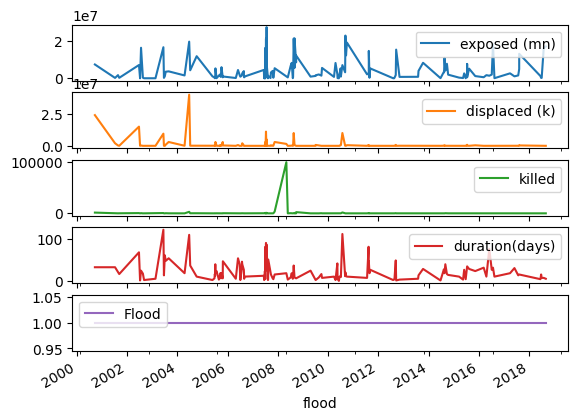

In [12]:
df_floods.plot(subplots=True)

In [13]:
date_range = pd.date_range(start='2000-09-01', end='2018-09-30', freq='D')
final_df = pd.DataFrame(index=date_range)

final_df['Flood'] = 0
final_df['Killed'] = np.nan
final_df['Exposed'] = np.nan
final_df['Duration'] = np.nan

for i, row in df_floods.iterrows():
    start_date = i
    end_date = start_date + pd.Timedelta(days=row['duration(days)'] - 1)

    final_df.loc[start_date:end_date, 'Flood'] = 1
    final_df.loc[start_date:end_date, 'Killed'] = row['killed']
    final_df.loc[start_date:end_date, 'exposed (mn)'] = row['exposed (mn)']
    final_df.loc[start_date:end_date, 'Duration(days)'] = row['duration(days)']

final_df['Killed'].fillna(0, inplace=True)
final_df.drop(columns=['Duration', 'Exposed'], inplace=True)
final_df.head()

,Flood,Killed,exposed (mn),Duration(days)
2000-09-01,0,0.0,NaN,NaN
2000-09-02,0,0.0,NaN,NaN
2000-09-03,0,0.0,NaN,NaN
2000-09-04,0,0.0,NaN,NaN
2000-09-05,0,0.0,NaN,NaN


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

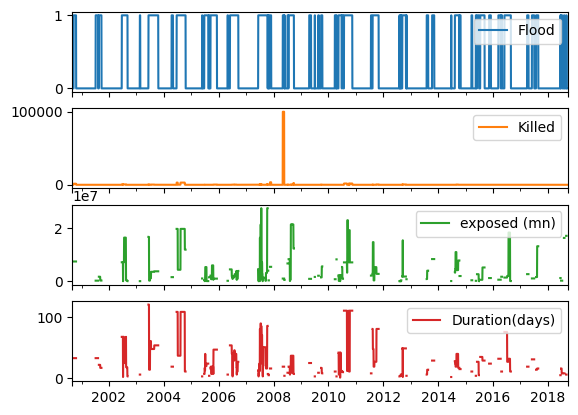

In [14]:
final_df.plot(subplots=True)

In [15]:
df_rain = aggregate_daily_rainfall(r'Datasets/rainfall.csv')

In [16]:
merged_df = pd.merge(final_df, df_rain, left_index=True,
                     right_index=True, how='left')
merged_df['rain (mm)'].fillna(0, inplace=True)
merged_df.rename(columns={
    'rain (mm)': 'Rain',
    'killed': 'Killed',
    'exposed (mn)': 'Exposed',
    'Duration(days)': 'Duration'}, inplace=True)

merged_df['KilledPerDay'] = np.where(merged_df['Flood'] > 0, np.nan, 0)
merged_df['ExposedPerDay'] = np.where(merged_df['Flood'] > 0, np.nan, 0)
merged_df.head()
merged_df.head()

,Flood,Killed,Exposed,Duration,Rain,KilledPerDay,ExposedPerDay
2000-09-01,0,0.0,NaN,NaN,16.8,0.0,0.0
2000-09-02,0,0.0,NaN,NaN,8.7,0.0,0.0
2000-09-03,0,0.0,NaN,NaN,11.9,0.0,0.0
2000-09-04,0,0.0,NaN,NaN,7.9,0.0,0.0
2000-09-05,0,0.0,NaN,NaN,4.1,0.0,0.0


In [17]:
for i in tqdm(range(len(df_floods.index)), desc="Formulating"):
    start_date = df_floods.index[i]
    end_date = (
        start_date+pd.Timedelta(days=df_floods['duration(days)'][i]-1)).date()

    flood_range = pd.date_range(start_date, end_date, freq='D')

    sum_rain = merged_df.loc[flood_range]['Rain'].sum()

    killed = df_floods['killed'][i]
    exposed = df_floods['exposed (mn)'][i]

    rain = merged_df.loc[flood_range]['Rain'].values

    merged_df.loc[flood_range, 'KilledPerDay'] = (killed/sum_rain)*rain
    merged_df.loc[flood_range, 'ExposedPerDay'] = (exposed/sum_rain)*rain

merged_df.drop(columns=['Exposed', 'Duration', 'Killed'], inplace=True)

Formulating:   0%|          | 0/147 [00:00<?, ?it/s]

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

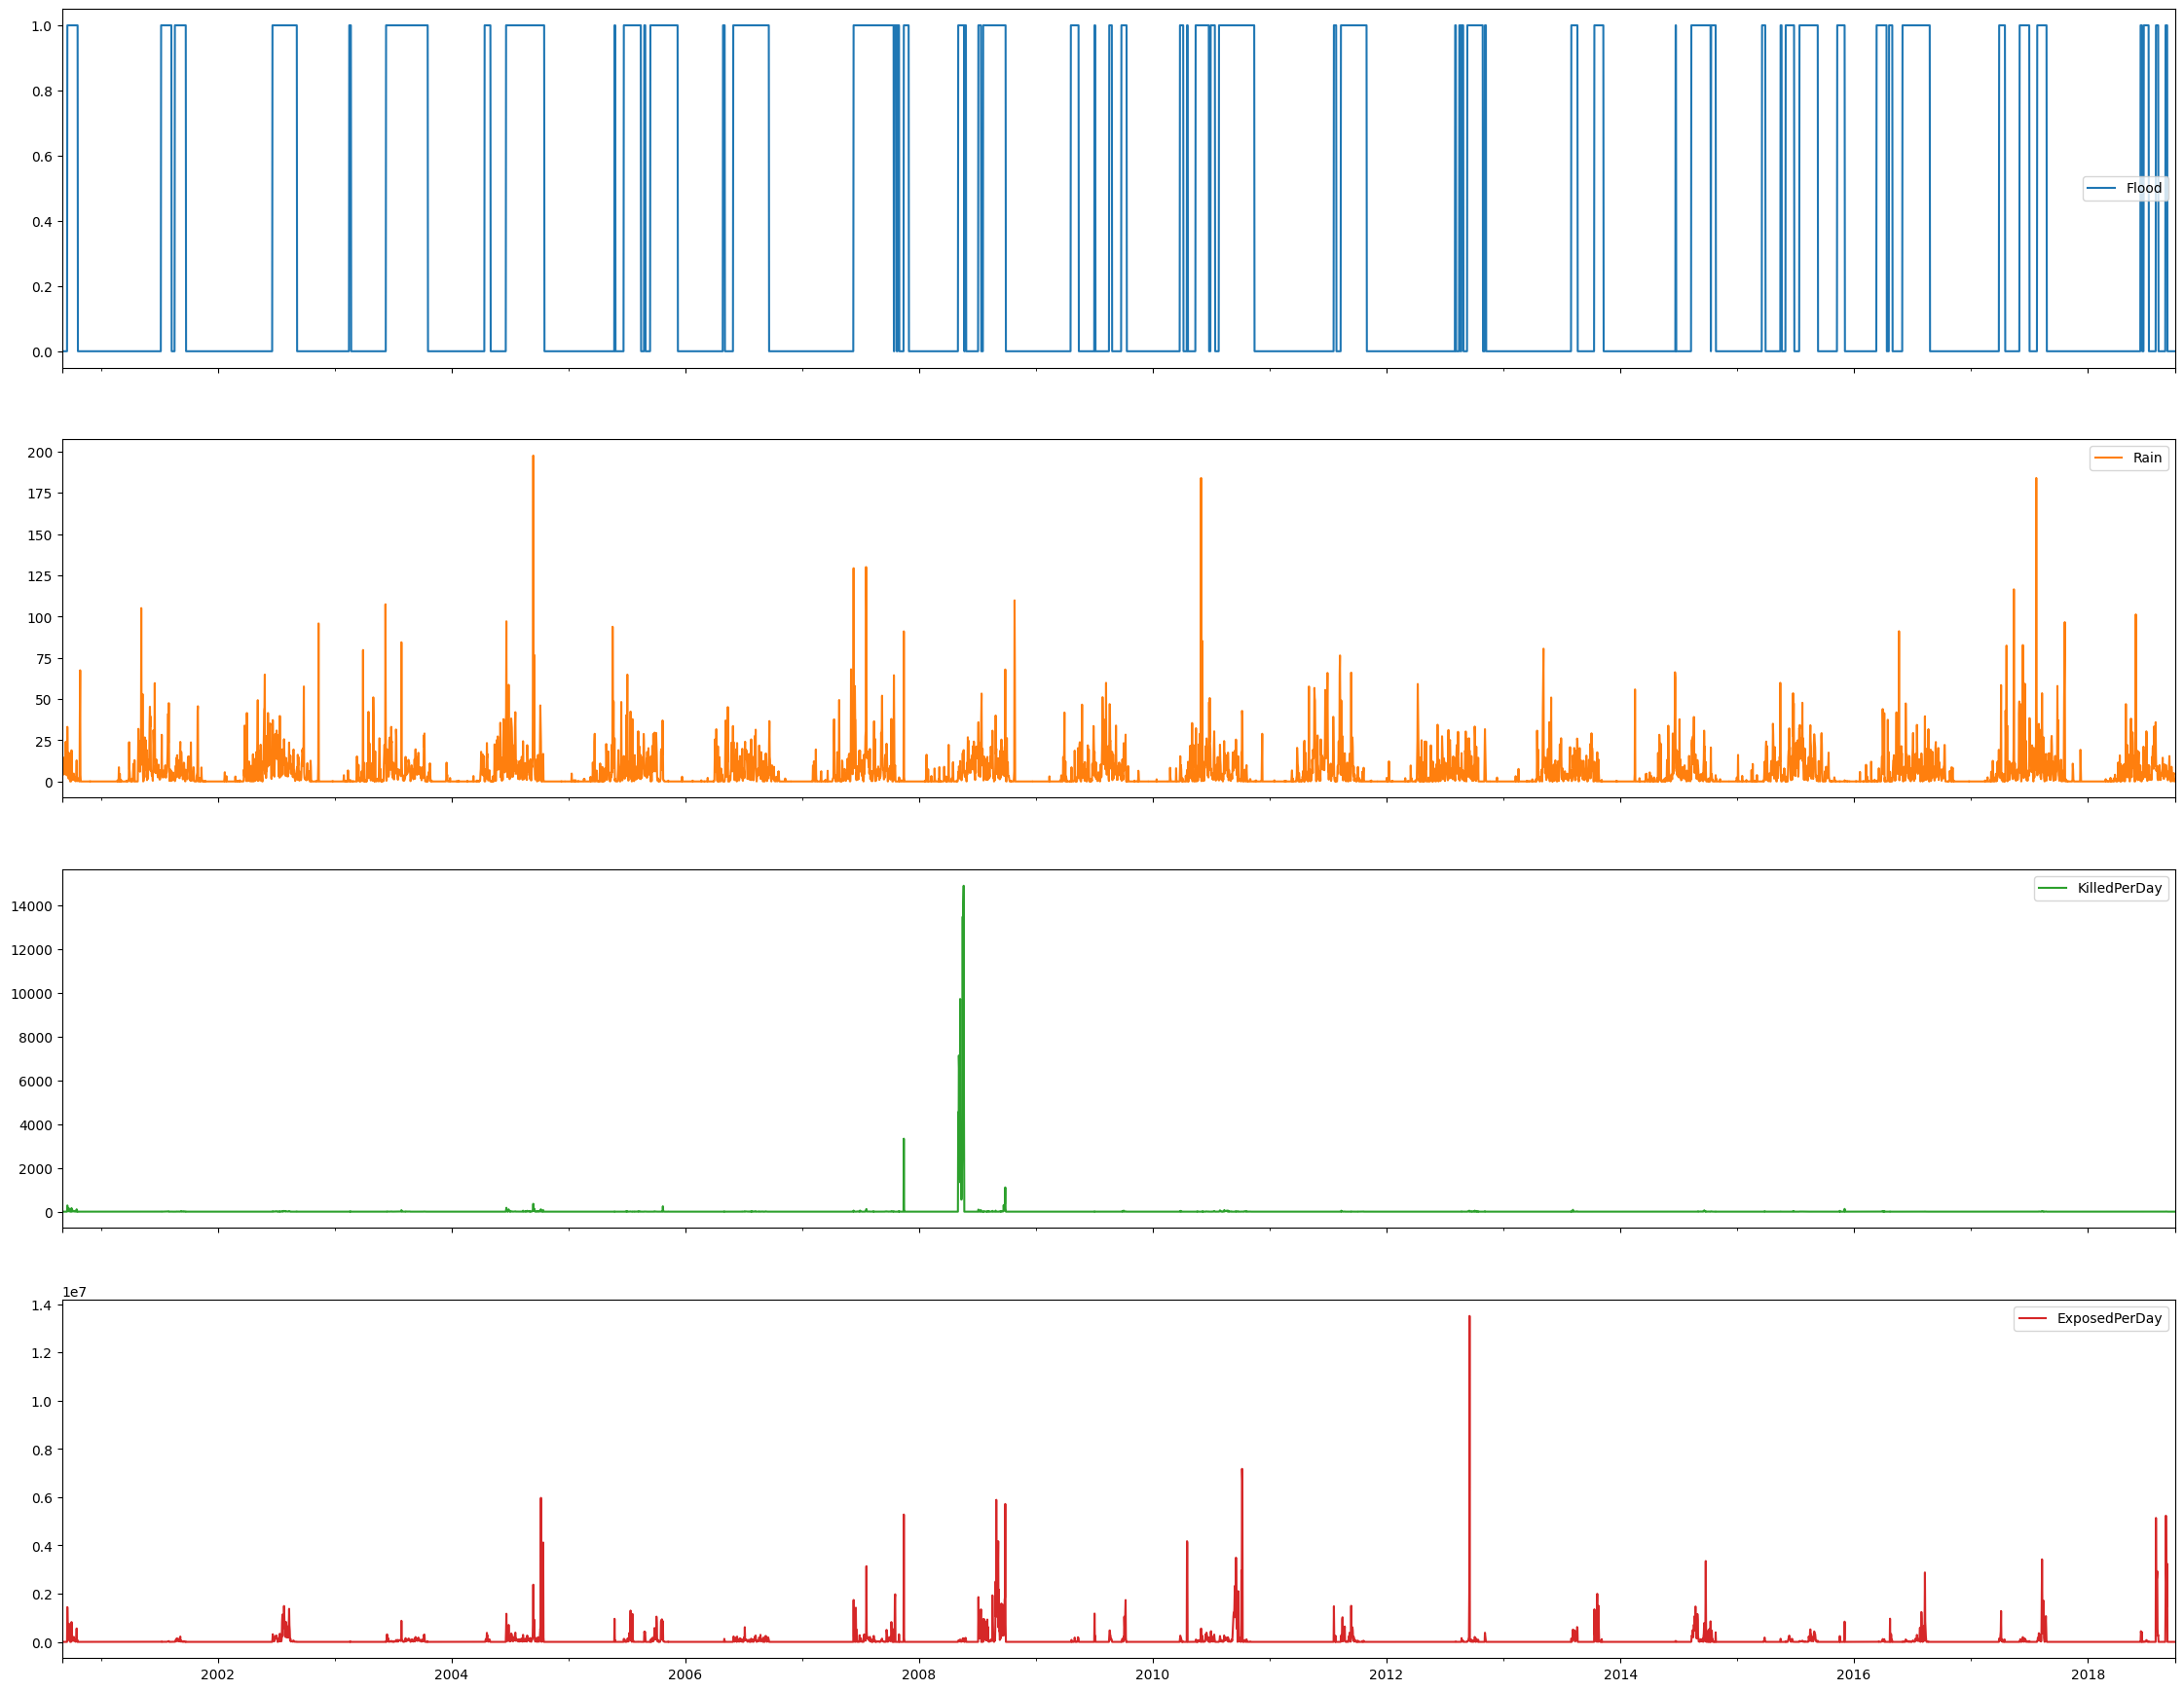

In [18]:
# merged_df.to_csv(r'Main.csv')
merged_df.plot(subplots=True, figsize=(28, 22))

In [19]:
merged_df.to_csv(r'Datasets/main_df.csv')

### Modelling & Forecasting


In [20]:
df = pd.read_csv(r'Datasets/main_df.csv',parse_dates=True, index_col='Unnamed: 0')

df.index = pd.to_datetime(df.index, format='%d-%m-%Y')

df.head()

,Flood,Rain,KilledPerDay,ExposedPerDay
2000-09-01,0,16.8,0.0,0.0
2000-09-02,0,8.7,0.0,0.0
2000-09-03,0,11.9,0.0,0.0
2000-09-04,0,7.9,0.0,0.0
2000-09-05,0,4.1,0.0,0.0


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

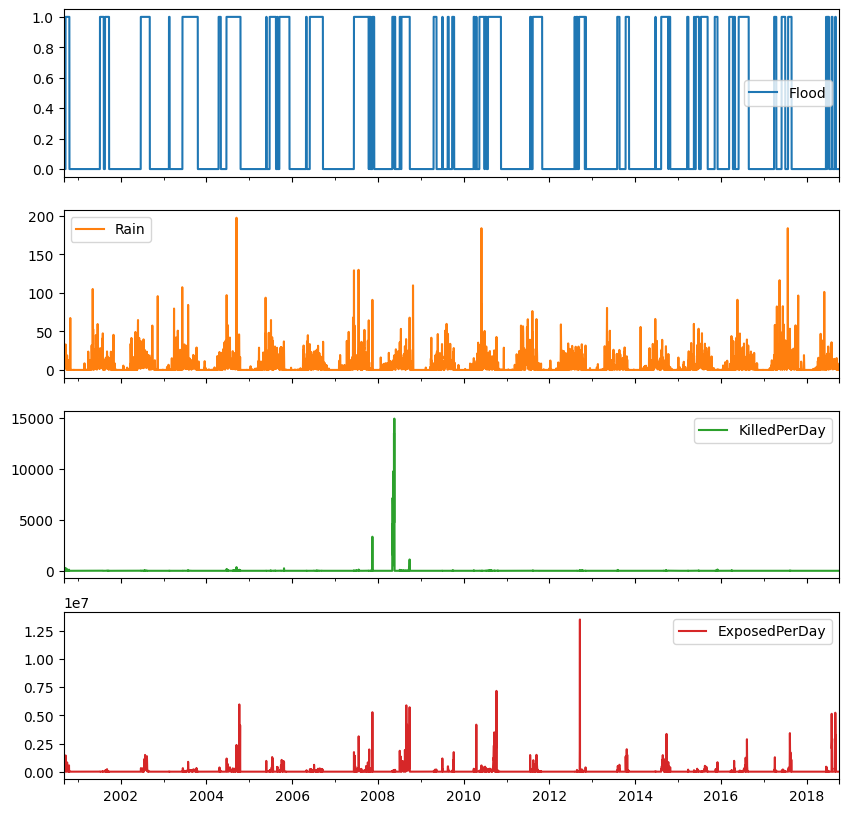

In [21]:
df.plot(subplots=True, figsize=(10, 10))

In [22]:
stationarity_test(df['Rain'], 'Rain')

The series Rain is stationary.


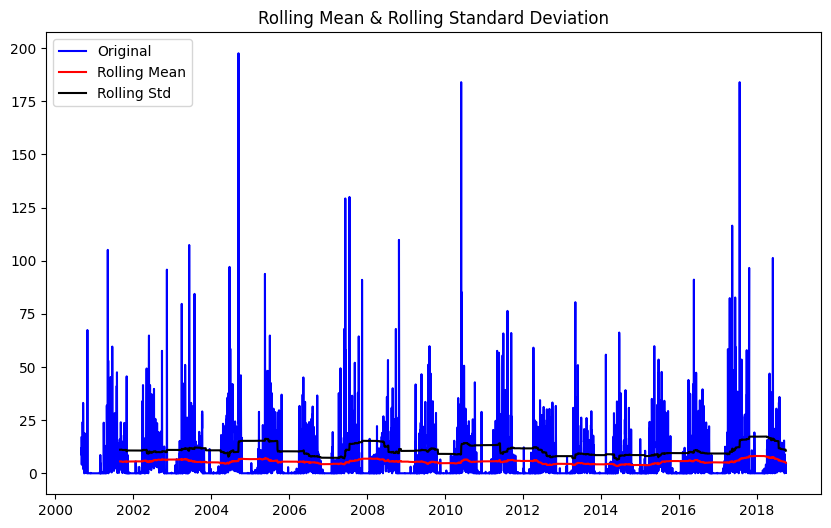

In [23]:
plot_rolling(df['Rain'], 365)
# The rolling plot shows that the mean and standard deviation are more or less constant over time.

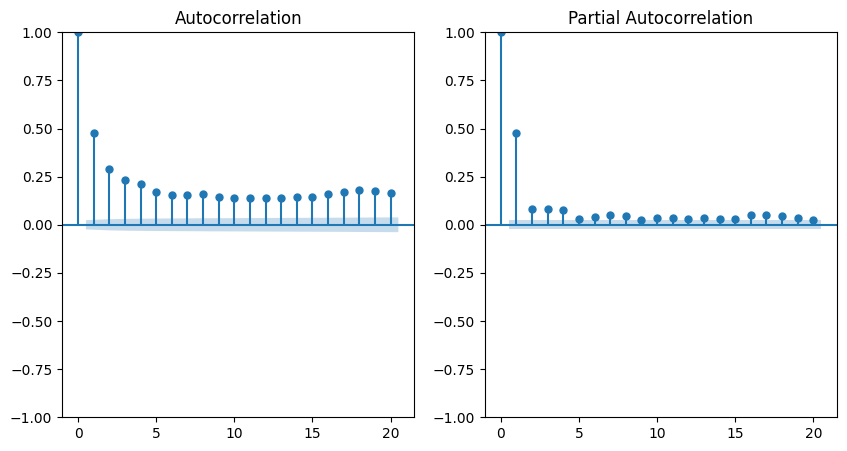

In [24]:
plot_acf_pacf(df['Rain'].dropna(), lags=20)

In [25]:
grid_search_df = grid_search(df['Rain'], p_max=5, q_max=5, d=0, sort_by='bic', model_type=SARIMAX)

Grid Search Progress:   0%|          | 0/25 [00:00<?, ?it/s]

,p,q,aic,bic
11,2,1,48719.388508,48746.570231
12,2,2,48721.068198,48755.045352
16,3,1,48721.095604,48755.072758
13,2,3,48721.666493,48762.439078
21,4,1,48721.733968,48762.506553


In [26]:
p_rain, q_rain = 2,1
period = 365 * int(input("Enter the number of years to forecast: "))
start_date = df.index[-1] + pd.Timedelta(days=1)
date_range = pd.date_range(start=start_date, periods=period, freq='D')

In [27]:
model = SARIMAX(df['Rain'], order=(p_rain, 0, q_rain)).fit()

In [28]:
forecast_rain = model.forecast(steps=period) + df['Rain'].iloc[-period:].values
pred_rain = (model.predict(start=0, end=len(df['Rain']) - 1) + df['Rain'].values).clip(lower=0)

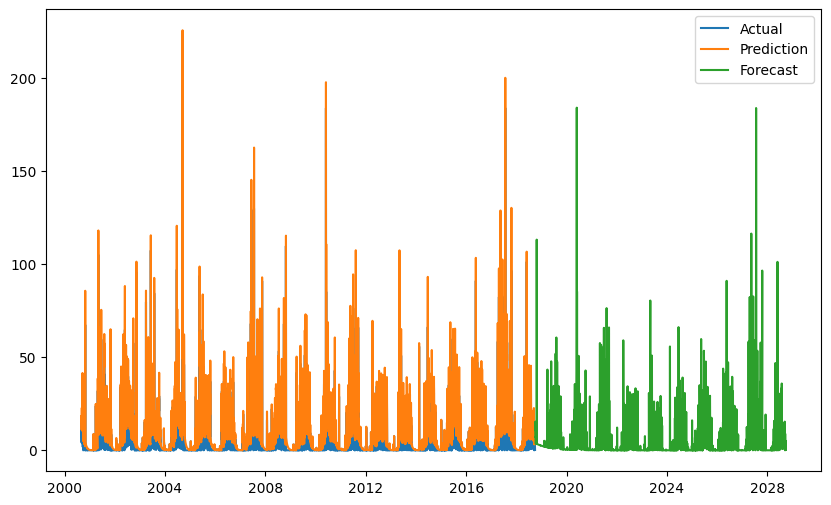

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(df['Rain'], label='Actual')
plt.plot(pred_rain, label='Prediction')
plt.plot(date_range, forecast_rain, label='Forecast')
plt.legend()
plt.show()

In [30]:
# RMSE to determine how much error in rainfall prediction
rmse_rain = rmse(pred_rain, df['Rain'])
print(f"RMSE: {rmse_rain} mm")

RMSE: 7.878372956947325 mm


In [31]:
forecast_df = aggregate_daily_rainfall('Datasets/forecast.csv')
rmse_rain = rmse(forecast_df['rain (mm)'].values,forecast_rain[:len(forecast_df)])
print(f"RMSE: {rmse_rain} mm")

RMSE: 13.31653246284265 mm
